## STAT 542 - Project 2 : Question 2 Models
##### Neeraj Wagh (nwagh2), Sunny Katiyar (sunnyk2), Pradnyesh Joshi (pvjoshi2)

######  Importing libraries

In [1]:
import random
import matplotlib.pyplot as plt
import cv2
random.seed(10)

### Importing Medical Features Generated Separately

In [2]:
import numpy as np
import pandas as pd
benign_data = pd.read_csv("./data/benign_test.csv")
malignant_data = pd.read_csv("./data/malignant_test.csv")

benign_data['is_malignant'] = np.zeros(len(benign_data))
malignant_data['is_malignant'] = np.ones(len(malignant_data))
feature_data = pd.concat([benign_data, malignant_data])
feature_data = feature_data.drop(['file_name'], axis=1)

feature_data = feature_data[['asymmetry_score', 'diameter', 'color_variation', 'circularity', 'is_malignant']]
 
feature_data = feature_data.replace([np.inf, -np.inf], np.nan)
feature_data = feature_data.dropna()

import random
random.seed(10)
# feature_data = feature_data.sample(frac=1).reset_index(drop=True)

In [3]:
feature_data.head()

asymmetry_score  diameter  color_variation  circularity  is_malignant
0            0.241     752.0            0.374       15.896           0.0
1            0.166     592.0            0.289       18.513           0.0
2            0.192     765.0            0.118       40.877           0.0
3            0.098     342.0            0.059       50.549           0.0
4            0.386    1502.0            0.198       50.216           0.0

### Train-Test Split

In [4]:
x = feature_data.iloc[:,0:feature_data.shape[1]-1].values
y = feature_data.iloc[:,feature_data.shape[1]-1].values
 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

###### Defining the accuracy function

In [5]:
def accuracy(y, y_hat):
    return (y_hat == y).mean()

# Model 1: XGBoost

######  Hyperparameter tuning using GridSearchCV

In [12]:
from xgboost import XGBClassifier
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1],
        'reg_alpha': [2, 4],
        'reg_lambda': [4, 6],
        'gamma': [2, 4],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.2, 0.4],
        'max_depth': [3],
        'n_estimators': [1500, 2000]
        }
xgb = XGBClassifier(learning_rate=0.01, objective='binary:logistic',
                    silent=True, nthread=-1, random_state=0)

In [13]:
xgb_model = GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=5, verbose=1)

In [14]:
import warnings, time
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
start_time = time.time()
xgb_model.fit(x_train, y_train)
print("finished tuning XGBoost in ", time.time()-start_time)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for

finished tuning XGBoost in  23.298027992248535


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   23.0s finished


######  Predicting on train and test

In [15]:
yhat_train = xgb_model.predict(x_train)
yhat_test = xgb_model.predict(x_test)

###### Checking train accuracy

In [16]:
accuracy(y_train, yhat_train)

0.7211538461538461

###### Checking test accuracy

In [17]:
accuracy(y_test, yhat_test)

0.6888888888888889

###### Checking other model performance scores

In [19]:
from sklearn.metrics import classification_report, roc_auc_score
from pprint import pprint

pprint(classification_report(y_train, yhat_train))
pprint(classification_report(y_test, yhat_test))

print(roc_auc_score(y_train, yhat_train))
print(roc_auc_score(y_test, yhat_test))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.70      0.83      0.76       111\n'
 '        1.0       0.75      0.60      0.67        97\n'
 '\n'
 'avg / total       0.73      0.72      0.72       208\n')
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.59      0.81      0.68        37\n'
 '        1.0       0.82      0.60      0.70        53\n'
 '\n'
 'avg / total       0.73      0.69      0.69        90\n')
0.7133834865793629
0.7072921978582355


###### Plotting feature importance

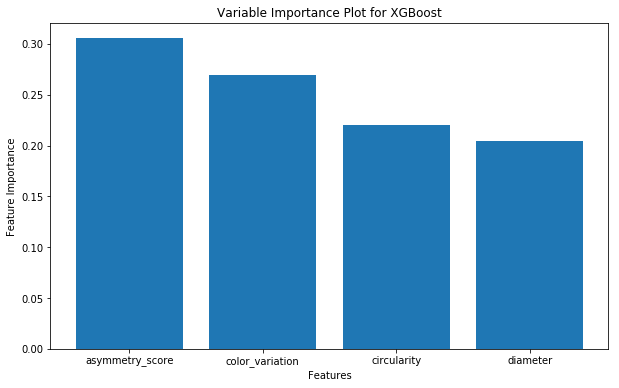

In [46]:
import pandas as pd

feature_imp = xgb_model.best_estimator_.feature_importances_
pc = list(feature_data.columns[0:4])
fimp_df = pd.DataFrame({'feature_importance': feature_imp, 'pc':pc})
fimp_df.sort_values(by = 'feature_importance', ascending=False, inplace=True)
fimp_df.reset_index(inplace=True)

plt.figure(figsize=(10,6))
plt.bar(fimp_df.pc, fimp_df.feature_importance)
plt.title('Variable Importance Plot for XGBoost')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

In [41]:
xgb_model.best_estimator_.feature_importances_

array([0.30562034, 0.20428857, 0.26953346, 0.2205577 ], dtype=float32)

In [43]:
list(feature_data.columns[0:4])

['asymmetry_score', 'diameter', 'color_variation', 'circularity']

# SVM

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

######  Hyperparameter tuning using GridSearchCV

In [23]:
random.seed(10)
start_time = time.time()
 
# defining parameter range
param_grid = {'C': [1e-6, 1e-4, 1e-2, 0.1],
              'kernel': ['linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv=5)
  
# fitting the model for grid search
grid.fit(x_train, y_train)
grid.best_params_
print("finished tuning SVM in ", time.time()-start_time)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.0s finished


finished tuning SVM in  3.892900228500366


In [24]:
best_SVM_model = grid.best_estimator_

###### Checking train accuracy

In [25]:
yhat_train = best_SVM_model.predict(x_train)
accuracy(y_train, yhat_train)

0.6346153846153846

###### Checking test accuracy

In [26]:
yhat_test = best_SVM_model.predict(x_test)
accuracy(y_test, yhat_test)

0.5

In [27]:
grid.best_params_

{'C': 0.1, 'kernel': 'linear'}

###### Checking other model performance scores

In [28]:
from sklearn.metrics import classification_report, roc_auc_score
from pprint import pprint
pprint(classification_report(y_train, yhat_train))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.60      0.95      0.73       111\n'
 '        1.0       0.82      0.28      0.42        97\n'
 '\n'
 'avg / total       0.70      0.63      0.59       208\n')


In [29]:
pprint(classification_report(y_test, yhat_test))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.44      0.86      0.59        37\n'
 '        1.0       0.72      0.25      0.37        53\n'
 '\n'
 'avg / total       0.61      0.50      0.46        90\n')


In [30]:
roc_auc_score(y_train, yhat_train)

0.6121482307049317

In [31]:
roc_auc_score(y_test, yhat_test)

0.5550739418663947

###### Plotting the coefficients of SVM Model

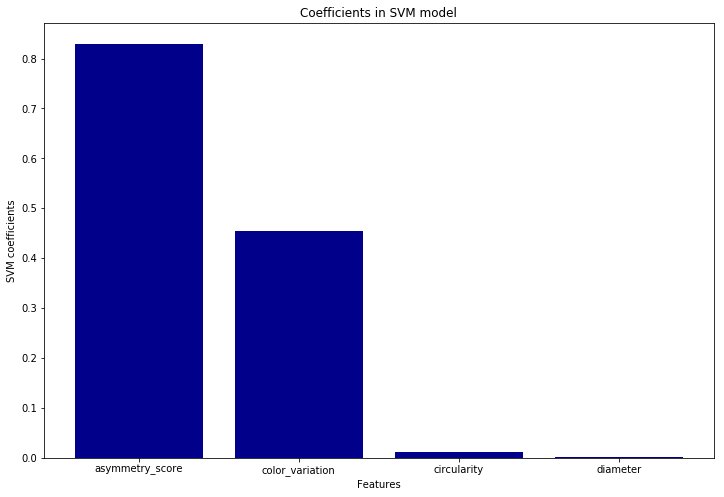

In [51]:
svm_coef = best_SVM_model.coef_
# pc_names = ["pc" + str(i) for i in range(0,100)]
pc_names = list(feature_data.columns[0:4])
 
svm_coef = svm_coef.reshape(svm_coef.shape[1])
 
fimp_df = pd.DataFrame({'svm_coef': svm_coef, 'pc_names':pc_names})
fimp_df['abs_coef'] = fimp_df['svm_coef'].abs()
fimp_df.sort_values(by = 'abs_coef', ascending=False, inplace=True)
fimp_df.reset_index(inplace=True)
 
n_pc=20
fig = plt.figure(figsize=(12,8))
#plt.figure
plt.bar(fimp_df.pc_names[0:n_pc], fimp_df.svm_coef[0:n_pc], color=['darkblue'])
plt.title('Coefficients in SVM model')
plt.xlabel('Features')
plt.ylabel('SVM coefficients')
plt.show()
#fig.savefig('svm_coef.png')

In [49]:
best_SVM_model.coef_

array([[8.29721245e-01, 7.98458908e-04, 4.54025431e-01, 1.09273580e-02]])